In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=True)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion3/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion3/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


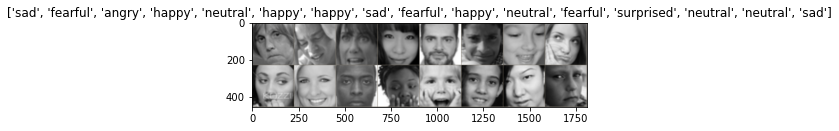

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 20
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.0001_adam_batch16_epoch20.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/20], Step [0/1248], Loss: 13.2281
Epoch [1/20], Step [20/1248], Loss: 2.9604
Epoch [1/20], Step [40/1248], Loss: 1.6774
Epoch [1/20], Step [60/1248], Loss: 1.6810
Epoch [1/20], Step [80/1248], Loss: 1.8763
Epoch [1/20], Step [100/1248], Loss: 1.6521
Epoch [1/20], Step [120/1248], Loss: 1.7505
Epoch [1/20], Step [140/1248], Loss: 1.7634
Epoch [1/20], Step [160/1248], Loss: 2.0135
Epoch [1/20], Step [180/1248], Loss: 1.9273
Epoch [1/20], Step [200/1248], Loss: 1.8327
Epoch [1/20], Step [220/1248], Loss: 1.7678
Epoch [1/20], Step [240/1248], Loss: 1.8484
Epoch [1/20], Step [260/1248], Loss: 1.7404
Epoch [1/20], Step [280/1248], Loss: 1.8031
Epoch [1/20], Step [300/1248], Loss: 1.6563
Epoch [1/20], Step [320/1248], Loss: 1.8500
Epoch [1/20], Step [340/1248], Loss: 1.7735
Epoch [1/20], Step [360/1248], Loss: 1.7907
Epoch [1/20], Step [380/1248], Loss: 1.7566
Epoch [1/20], Step [400/1248], Loss: 1.7028
Epoch [1/20], Step [420/1248], Loss: 1.8233
Epoch [1/20], Step [440/1248

Epoch [3/20], Step [1100/1248], Loss: 1.7830
Epoch [3/20], Step [1120/1248], Loss: 1.6358
Epoch [3/20], Step [1140/1248], Loss: 1.5641
Epoch [3/20], Step [1160/1248], Loss: 1.7817
Epoch [3/20], Step [1180/1248], Loss: 1.8221
Epoch [3/20], Step [1200/1248], Loss: 1.8539
Epoch [3/20], Step [1220/1248], Loss: 1.9697
Epoch [3/20], Step [1240/1248], Loss: 1.7927

train-loss: 1.8517, train-acc: 24.5942
validation loss: 4.6759, validation acc: 26.0243

Epoch 4

Epoch [4/20], Step [0/1248], Loss: 1.9472
Epoch [4/20], Step [20/1248], Loss: 1.7685
Epoch [4/20], Step [40/1248], Loss: 1.9668
Epoch [4/20], Step [60/1248], Loss: 1.7272
Epoch [4/20], Step [80/1248], Loss: 1.5460
Epoch [4/20], Step [100/1248], Loss: 1.5719
Epoch [4/20], Step [120/1248], Loss: 1.7813
Epoch [4/20], Step [140/1248], Loss: 1.9732
Epoch [4/20], Step [160/1248], Loss: 1.7988
Epoch [4/20], Step [180/1248], Loss: 1.7589
Epoch [4/20], Step [200/1248], Loss: 1.7200
Epoch [4/20], Step [220/1248], Loss: 1.8493
Epoch [4/20], Step 

Epoch [6/20], Step [880/1248], Loss: 1.2851
Epoch [6/20], Step [900/1248], Loss: 0.9733
Epoch [6/20], Step [920/1248], Loss: 0.9675
Epoch [6/20], Step [940/1248], Loss: 0.9132
Epoch [6/20], Step [960/1248], Loss: 1.6903
Epoch [6/20], Step [980/1248], Loss: 1.4661
Epoch [6/20], Step [1000/1248], Loss: 1.7830
Epoch [6/20], Step [1020/1248], Loss: 1.4915
Epoch [6/20], Step [1040/1248], Loss: 1.1854
Epoch [6/20], Step [1060/1248], Loss: 1.1207
Epoch [6/20], Step [1080/1248], Loss: 1.5192
Epoch [6/20], Step [1100/1248], Loss: 1.1479
Epoch [6/20], Step [1120/1248], Loss: 1.2676
Epoch [6/20], Step [1140/1248], Loss: 1.0827
Epoch [6/20], Step [1160/1248], Loss: 1.3667
Epoch [6/20], Step [1180/1248], Loss: 1.1241
Epoch [6/20], Step [1200/1248], Loss: 0.7408
Epoch [6/20], Step [1220/1248], Loss: 1.1341
Epoch [6/20], Step [1240/1248], Loss: 1.7200

train-loss: 1.6775, train-acc: 49.1032
validation loss: 3.0594, validation acc: 47.9514

Improvement-Detected, save-model
Epoch 7

Epoch [7/20], Step 

Epoch [9/20], Step [640/1248], Loss: 0.7135
Epoch [9/20], Step [660/1248], Loss: 1.1007
Epoch [9/20], Step [680/1248], Loss: 0.9934
Epoch [9/20], Step [700/1248], Loss: 1.4881
Epoch [9/20], Step [720/1248], Loss: 1.1800
Epoch [9/20], Step [740/1248], Loss: 0.8441
Epoch [9/20], Step [760/1248], Loss: 0.9946
Epoch [9/20], Step [780/1248], Loss: 1.2987
Epoch [9/20], Step [800/1248], Loss: 1.4188
Epoch [9/20], Step [820/1248], Loss: 0.9649
Epoch [9/20], Step [840/1248], Loss: 0.9878
Epoch [9/20], Step [860/1248], Loss: 1.3206
Epoch [9/20], Step [880/1248], Loss: 0.6388
Epoch [9/20], Step [900/1248], Loss: 0.9823
Epoch [9/20], Step [920/1248], Loss: 0.9828
Epoch [9/20], Step [940/1248], Loss: 1.0204
Epoch [9/20], Step [960/1248], Loss: 0.9528
Epoch [9/20], Step [980/1248], Loss: 1.0854
Epoch [9/20], Step [1000/1248], Loss: 0.7569
Epoch [9/20], Step [1020/1248], Loss: 1.1566
Epoch [9/20], Step [1040/1248], Loss: 1.0214
Epoch [9/20], Step [1060/1248], Loss: 1.1789
Epoch [9/20], Step [1080/124

Epoch [12/20], Step [360/1248], Loss: 0.7677
Epoch [12/20], Step [380/1248], Loss: 0.9135
Epoch [12/20], Step [400/1248], Loss: 0.9160
Epoch [12/20], Step [420/1248], Loss: 0.9212
Epoch [12/20], Step [440/1248], Loss: 0.7243
Epoch [12/20], Step [460/1248], Loss: 0.8891
Epoch [12/20], Step [480/1248], Loss: 0.9065
Epoch [12/20], Step [500/1248], Loss: 1.2172
Epoch [12/20], Step [520/1248], Loss: 1.0656
Epoch [12/20], Step [540/1248], Loss: 0.6344
Epoch [12/20], Step [560/1248], Loss: 1.0961
Epoch [12/20], Step [580/1248], Loss: 0.8663
Epoch [12/20], Step [600/1248], Loss: 0.7623
Epoch [12/20], Step [620/1248], Loss: 0.9185
Epoch [12/20], Step [640/1248], Loss: 0.7408
Epoch [12/20], Step [660/1248], Loss: 0.9870
Epoch [12/20], Step [680/1248], Loss: 0.6862
Epoch [12/20], Step [700/1248], Loss: 1.0700
Epoch [12/20], Step [720/1248], Loss: 0.7256
Epoch [12/20], Step [740/1248], Loss: 0.8587
Epoch [12/20], Step [760/1248], Loss: 1.1038
Epoch [12/20], Step [780/1248], Loss: 0.7202
Epoch [12/

Epoch [15/20], Step [80/1248], Loss: 0.8076
Epoch [15/20], Step [100/1248], Loss: 0.5652
Epoch [15/20], Step [120/1248], Loss: 1.1811
Epoch [15/20], Step [140/1248], Loss: 0.5732
Epoch [15/20], Step [160/1248], Loss: 0.9272
Epoch [15/20], Step [180/1248], Loss: 0.5406
Epoch [15/20], Step [200/1248], Loss: 0.6549
Epoch [15/20], Step [220/1248], Loss: 0.5527
Epoch [15/20], Step [240/1248], Loss: 0.5224
Epoch [15/20], Step [260/1248], Loss: 1.1219
Epoch [15/20], Step [280/1248], Loss: 0.6588
Epoch [15/20], Step [300/1248], Loss: 0.4041
Epoch [15/20], Step [320/1248], Loss: 0.6189
Epoch [15/20], Step [340/1248], Loss: 0.5316
Epoch [15/20], Step [360/1248], Loss: 0.5753
Epoch [15/20], Step [380/1248], Loss: 0.9843
Epoch [15/20], Step [400/1248], Loss: 0.7665
Epoch [15/20], Step [420/1248], Loss: 1.4656
Epoch [15/20], Step [440/1248], Loss: 0.6938
Epoch [15/20], Step [460/1248], Loss: 0.8508
Epoch [15/20], Step [480/1248], Loss: 0.5830
Epoch [15/20], Step [500/1248], Loss: 0.9708
Epoch [15/2

Epoch [17/20], Step [1120/1248], Loss: 0.5895
Epoch [17/20], Step [1140/1248], Loss: 0.4792
Epoch [17/20], Step [1160/1248], Loss: 0.2610
Epoch [17/20], Step [1180/1248], Loss: 0.5462
Epoch [17/20], Step [1200/1248], Loss: 0.4546
Epoch [17/20], Step [1220/1248], Loss: 0.2929
Epoch [17/20], Step [1240/1248], Loss: 0.9189

train-loss: 1.1670, train-acc: 79.6293
validation loss: 1.7655, validation acc: 62.9742

Epoch 18

Epoch [18/20], Step [0/1248], Loss: 0.4986
Epoch [18/20], Step [20/1248], Loss: 0.3908
Epoch [18/20], Step [40/1248], Loss: 0.5033
Epoch [18/20], Step [60/1248], Loss: 0.2407
Epoch [18/20], Step [80/1248], Loss: 0.2937
Epoch [18/20], Step [100/1248], Loss: 0.5499
Epoch [18/20], Step [120/1248], Loss: 0.1743
Epoch [18/20], Step [140/1248], Loss: 0.1675
Epoch [18/20], Step [160/1248], Loss: 0.1945
Epoch [18/20], Step [180/1248], Loss: 0.3511
Epoch [18/20], Step [200/1248], Loss: 0.4456
Epoch [18/20], Step [220/1248], Loss: 0.9579
Epoch [18/20], Step [240/1248], Loss: 0.5598

Epoch [20/20], Step [860/1248], Loss: 0.4154
Epoch [20/20], Step [880/1248], Loss: 0.4716
Epoch [20/20], Step [900/1248], Loss: 0.1480
Epoch [20/20], Step [920/1248], Loss: 0.8623
Epoch [20/20], Step [940/1248], Loss: 0.3846
Epoch [20/20], Step [960/1248], Loss: 0.5040
Epoch [20/20], Step [980/1248], Loss: 0.4683
Epoch [20/20], Step [1000/1248], Loss: 0.5160
Epoch [20/20], Step [1020/1248], Loss: 0.6154
Epoch [20/20], Step [1040/1248], Loss: 0.2827
Epoch [20/20], Step [1060/1248], Loss: 0.8713
Epoch [20/20], Step [1080/1248], Loss: 0.0939
Epoch [20/20], Step [1100/1248], Loss: 0.2325
Epoch [20/20], Step [1120/1248], Loss: 0.3509
Epoch [20/20], Step [1140/1248], Loss: 0.3691
Epoch [20/20], Step [1160/1248], Loss: 0.3131
Epoch [20/20], Step [1180/1248], Loss: 0.1878
Epoch [20/20], Step [1200/1248], Loss: 0.6741
Epoch [20/20], Step [1220/1248], Loss: 0.2164
Epoch [20/20], Step [1240/1248], Loss: 0.2465

train-loss: 1.0530, train-acc: 87.8106
validation loss: 1.7032, validation acc: 62.392

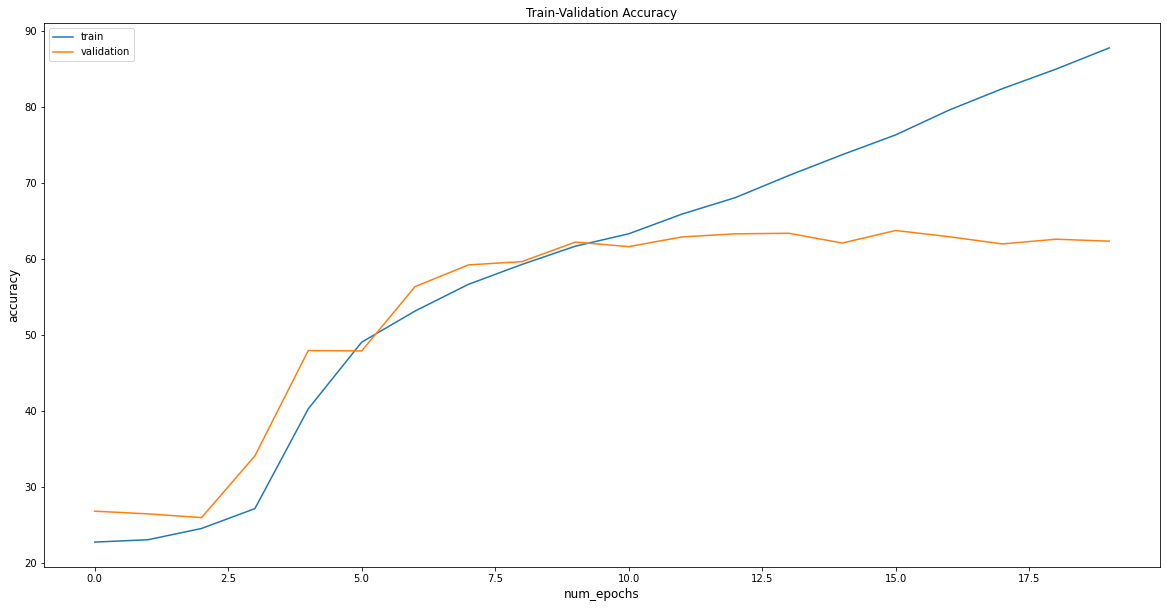

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

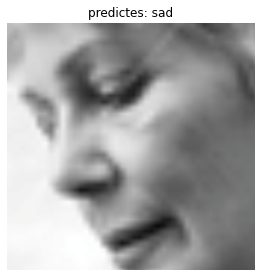

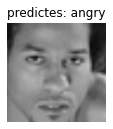

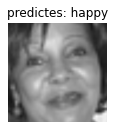

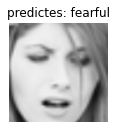

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()